# pomp example: Simulating  the Gompertz model
Example how to use R library *pomp* to simulate from the Gompertz model.

Sources:
- <a href="https://kingaa.github.io/pomp/vignettes/pompjss.pdf">This</a> paper section 4.1.
- https://kingaa.github.io/pomp/vignettes/R_v_C.html

**Gompertz model**


\begin{align*}
& X_{t+\Delta t} = K^{1-S} X_t^S \epsilon_t \label{eq1}\tag{1}\\[4pt]
& S = e^{-r \Delta t} \label{eq2}\tag{3} \\[4pt]
& \epsilon_t \sim \text{LogNormal}(0, \sigma), \ \ i.i.d \label{eq3}\tag{3} \\[4pt]
& Y_t \sim \text{LogNormal}(log X_t, \tau) \label{eq4}\tag{4}
\end{align*}

where

\begin{align*}
& X_{t} \text{ : Population density at time $t$ (latent variable). } \\[4pt]
& Y_{t} \text{ : Observed population density at time $t$ ($X_t$ measured with error). } \\[4pt]
& K \text{ : Carrying capacity of population.} \\[4pt]
\end{align*}

Notice that

\begin{align*}
& log \epsilon_t \equiv log \ \epsilon_t \sim \text{Normal}(0, \sigma), \ \ i.i.d \label{eq5}\tag{5} \\[4pt]
\end{align*}

In [1]:
#install.packages("pomp")

In [1]:
require(pomp)
require(ggplot2)
require(magrittr)
require(repr)
options(repr.plot.width=10, repr.plot.height=4)
sessionInfo()

Loading required package: pomp
Welcome to pomp version 2!
For information on upgrading your pomp version < 2 code, see the
'pomp version 2 upgrade guide' at https://kingaa.github.io/pomp/.
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: magrittr
Loading required package: repr


R version 3.6.1 (2019-07-05)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17763)

Matrix products: default

locale:
[1] LC_COLLATE=Finnish_Finland.1252  LC_CTYPE=Finnish_Finland.1252   
[3] LC_MONETARY=Finnish_Finland.1252 LC_NUMERIC=C                    
[5] LC_TIME=Finnish_Finland.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] repr_0.19.2   magrittr_1.5  ggplot2_3.1.1 pomp_2.2     

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.2       compiler_3.6.1   pillar_1.3.1     plyr_1.8.4      
 [5] base64enc_0.1-3  tools_3.6.1      digest_0.6.20    uuid_0.1-2      
 [9] jsonlite_1.6     evaluate_0.14    tibble_2.1.1     gtable_0.3.0    
[13] lattice_0.20-38  pkgconfig_2.0.2  rlang_0.4.0      IRdisplay_0.7.0 
[17] IRkernel_0.8.15  mvtnorm_1.0-11   coda_0.19-3      withr_2.1.2     
[21] stringr_1.4.0    dplyr_0.8.0.1    grid_3.6.1       tidyselect_0.2.5
[25] d

### Function for method *rprocess*
Method *rprocess* simulates $f_{X_n | X_{n-1}} (x_n | x_{n-1};\theta)$.

In [2]:
rprocess_fun_R = function(X,r,K,sigma,...,delta.t) {
  eps    = exp(rnorm(n=1,mean=0,sd=sigma)) # eq 5, needs to be named "eps" although is logeps
  S      = exp(-r*delta.t) # eq 2; delta.t cannot be renamed!
  c(X    = K^(1-S)*X^S*eps ) # eq 1; needs to be give as vector
}

rprocess_fun_C = Csnippet("
    double S = exp(-r*dt);
    double logeps = (sigma > 0.0) ? rnorm(0,sigma) : 0.0;
    X = pow(K,(1-S))*pow(X,S)*exp(logeps);"
)

### Function for method *rmeasure*
Method *rmeasure* simulates $f_{Y_n | X_n} (y_n | x_n;\theta)$.

In [3]:
rmeasure_fun_R = function (X, tau, ...) {
    c( Y = rlnorm(n=1,meanlog=log(X),sdlog=tau) ) # eq4; needs to be give as vector
}

rmeasure_fun_C = Csnippet("
    Y = rlnorm(log(X),tau);"
)

### Function for method *dmeasure*
Method *dmeasure* evalueates $f_{Y_n | X_n} (y_n | x_n;\theta)$.

In [4]:
dmeasure_fun_R = function (tau, X, Y, ..., log) {
    dlnorm(x=Y, meanlog=log(X), sdlog=tau, log=log)
}

dmeasure_fun_C = Csnippet("
    lik = dlnorm(Y,log(X),tau,give_log);"
)

### Parameters

In [5]:
params = c(K=1, r=0.1, sigma=0.1, tau=0.1, X_0=1)

### Call *simulate* using R functions

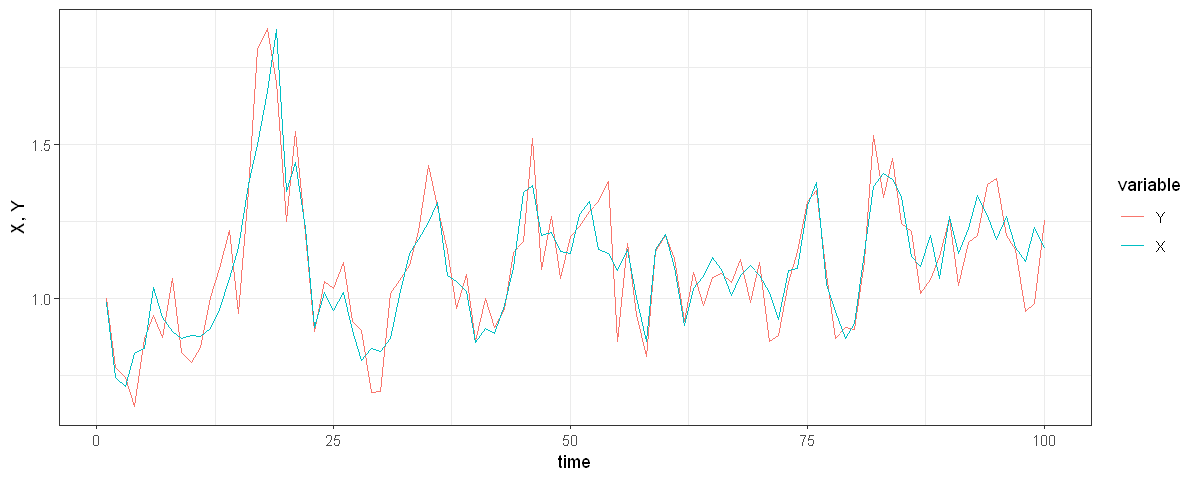

In [6]:
gompertz_R = 
    simulate(
        times = 1:100,
        t0 = 0,
        params = params,
        rprocess = discrete_time(
            rprocess_fun_R,
            delta.t=1 # cannot be renamed!
        ),
        rmeasure = rmeasure_fun_R,
        dmeasure = dmeasure_fun_R
    )

sim_data = as.data.frame(gompertz_R)
sim_data %>%
  melt(id="time") %>%
  ggplot(aes(x=time,y=value,color=variable))+
  geom_line()+
  labs(y="X, Y")+
  theme_bw()

### Call *simulate* using C functions

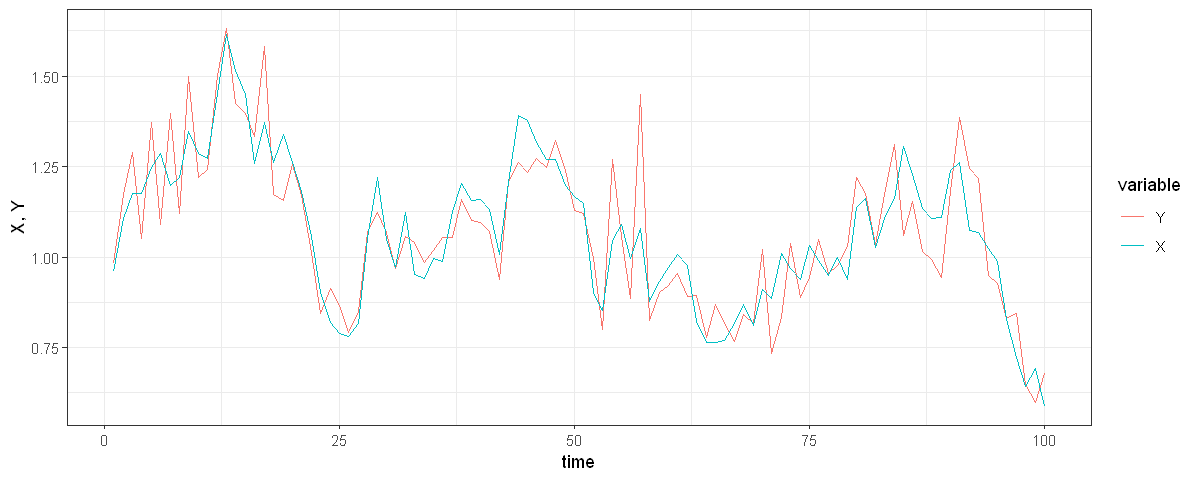

In [7]:
gompertz_C = 
    simulate(
        times = 1:100,
        t0 = 0,
        params = params,
        rprocess = discrete_time(
            rprocess_fun_C,
            delta.t=1 # cannot be renamed!
        ),
        rmeasure = rmeasure_fun_C,
        dmeasure = dmeasure_fun_C,
        paramnames=c("r","K","sigma","tau"),
        obsnames="Y",
        statenames="X"        
    )

sim_data = as.data.frame(gompertz_C)
sim_data %>%
  melt(id="time") %>%
  ggplot(aes(x=time,y=value,color=variable))+
  geom_line()+
  labs(y="X, Y")+
  theme_bw()